## Model setup XBeach 2D

Setup a 1D XBeach model with the Python toolbox 

In [10]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os

Import the toolbox and set the xbeach styleshoot for plotting

In [11]:
## import xbeach tools
sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools import xgrid, ygrid, seaward_extend, XBeachModelSetup, offshore_depth, seaward_extend, lateral_extend
plt.style.use(os.path.join('..','xbTools','xb.mplstyle'))

### Data
Load and plot the bathymetry data

Text(0.5, 0, 'y [m]')

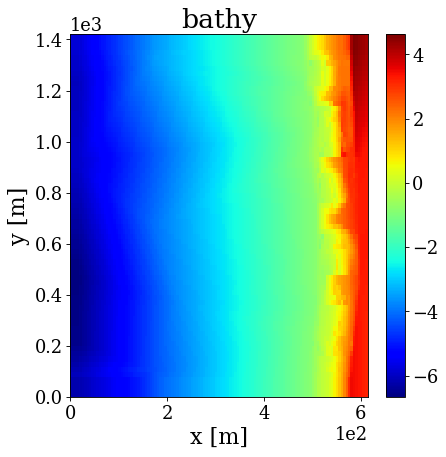

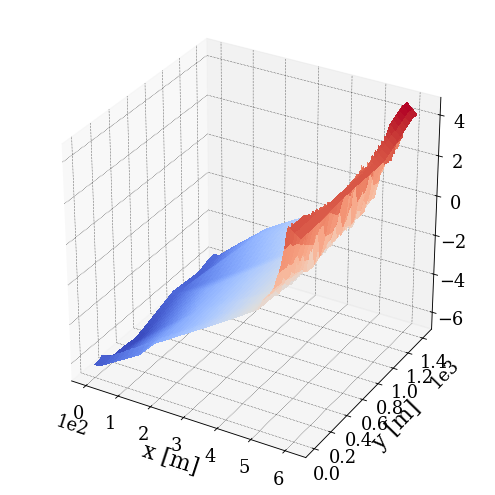

In [12]:
## load data
bathy = np.loadtxt('..//examples//clean//bathy.dep')


## set bathy grid
nx = 124
ny = 72
dx = 5
dy = 20

x = np.linspace(0,(nx-1)*dx,nx)
y = np.linspace(0,(ny-1)*dy,ny)

X, Y = np.meshgrid(x,y)

## plot
plt.figure()
plt.pcolor(x,y,bathy)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('bathy')

fig     = plt.figure()
ax      = Axes3D(fig)
surf    = ax.plot_surface(X, Y, bathy, cmap=cm.coolwarm,  linewidth=0, antialiased=False)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Create x-grid
Create spatially varying x-grid resolution.

Text(0, 0.5, 'z [m]')

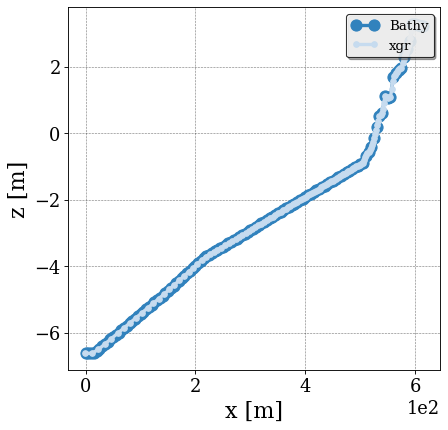

In [13]:
xgr,zgr = xgrid(x, bathy[20,:],dxmin=2)


plt.figure()
plt.plot(x,bathy[20,:],'-o')
plt.plot(xgr,zgr,'.-')
plt.legend(['Bathy','xgr'])
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Create y-grid
Create spatially varying y-grid resolution.

Enable optimization of transition distance
Area type center
Transition 142.0


D:\Repositories\xbeach_toolbox\xbeach-toolbox-trunk\xbTools\xbeachtools.py:471: RuntimeWarning: overflow encountered in power
  Lj[1] = cell1 * np.sum(np.power(fj[1],np.arange(1,ni+1,1)) )
D:\Repositories\xbeach_toolbox\xbeach-toolbox-trunk\xbTools\xbeachtools.py:472: RuntimeWarning: overflow encountered in double_scalars
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
D:\Repositories\xbeach_toolbox\xbeach-toolbox-trunk\xbTools\xbeachtools.py:472: RuntimeWarning: overflow encountered in power
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
D:\Repositories\xbeach_toolbox\xbeach-toolbox-trunk\xbTools\xbeachtools.py:462: RuntimeWarning: overflow encountered in double_scalars
  fj[1] = 1.1 * fj[1]


Text(0, 0.5, 'dy [m]')

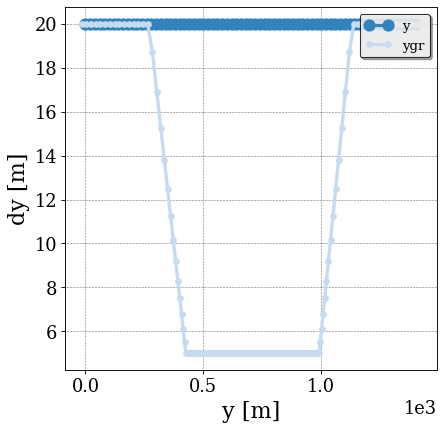

In [14]:
ygr = ygrid(y)

plt.figure()
plt.plot(y[:-1],np.diff(y),'-o')
plt.plot(ygr[:-1],np.diff(ygr),'.-')
plt.legend(['y','ygr'])
plt.xlabel('y [m]')
plt.ylabel('dy [m]')

### Interpolate
Interpolate data to new grid

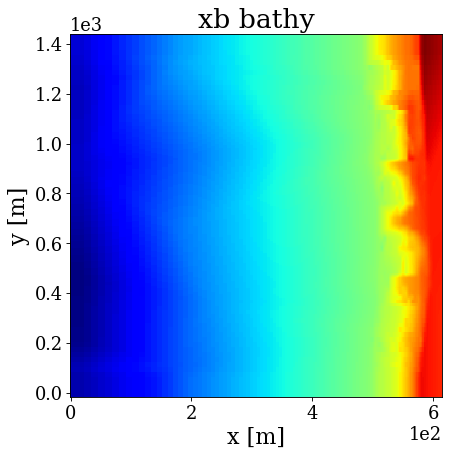

In [15]:
f = interpolate.interp2d(x, y, bathy, kind='linear')

zgr = f(xgr,ygr)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('xb bathy')


xgr, ygr = np.meshgrid(xgr,ygr)

### Seaward extend
Extend the grid to the required offshore depth. In this case 20 m with a artifial slope of 1/20.

Artificial slope of 1:10
Hm0,shoal = 7.429261752408249
d start = 24.716123801643437
Hm0,shoal/d profile = 1.1970569697686089
Hm0,shoal/d slope = 0.3005836114121689
n profile = 0.5248467628414396
n slope = 0.9437955288091868


Text(0, 0.5, 'z [m]')

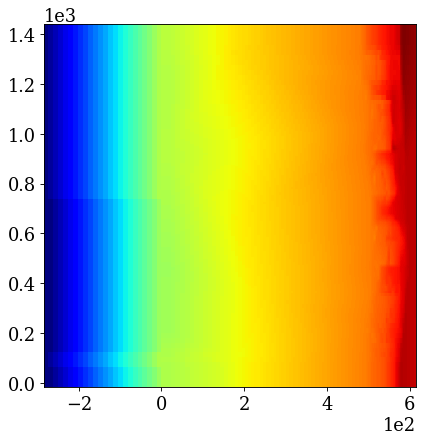

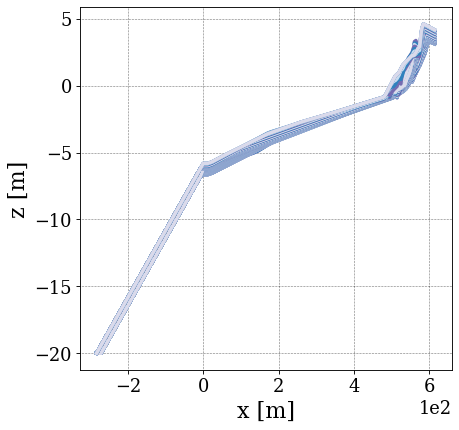

In [16]:
d_start, slope, Hm0_shoal = offshore_depth(Hm0=9, Tp=15, depth_offshore_profile=abs(bathy[0,0]), depth_boundary_conditions=20)

xgr, ygr, zgr = seaward_extend(xgr,ygr,zgr,slope=1/20,depth=-20)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

plt.figure()
plt.plot(xgr[:,:].T,zgr[:,:].T)
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Lateral extend
Extend the grid lateral with 5 rows

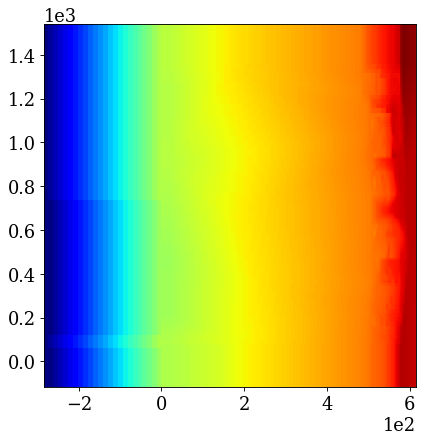

In [17]:
xgr,ygr,zgr = lateral_extend(xgr,ygr,zgr,n=5)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

### Create model setup
Create the model setup class

Test som 1


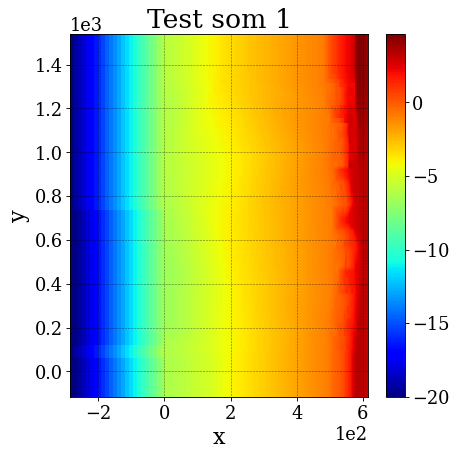

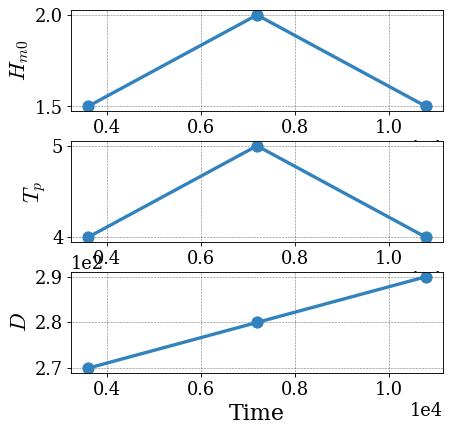

In [18]:
xb_setup = XBeachModelSetup('Test som 1')

print(xb_setup)

xb_setup.set_grid(xgr,ygr,zgr)

#xb_setup.set_waves('jons',{'Hm0':2,'Tp':5,'gammajsp':3.3, 's' : 10000, 'mainang':270,'fnyq':1})
xb_setup.set_waves('jonstable',{'Hm0':[1.5, 2, 1.5],'Tp':[4, 5, 4],'gammajsp':[3.3, 3.3, 3.3], 's' : [20,20,20], 'mainang':[270,280, 290],'duration':[3600, 3600, 3600],'dtbc':[1,1,1]})

xb_setup.set_params({'Wavemodel':'surfbeat',
                     'morphology':0,
                     'befriccoef':0.01,
                     'tstop':3600,
                     'nglobalvar':['zb','zs','H'],
                     'npointvar':['zs','H'],
                     'nmeanvar':['zb'],
                     'npoints':['1 0', '6 0', '10 0', '12 0']})


sim_path = os.path.join('xb-2D')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)
xb_setup.write_model(os.path.join(sim_path))